## Color Transfer Whales

### Auxilary functions (described in the previous post)

In [2]:
%matplotlib inline

from matplotlib import pyplot as plt
from os import path
import numpy as np
import cv2
import pandas as pd

# display a list of images with titles
def show_images(images,titles=None, scale=1.3):
    """Display a list of images"""
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n) # Make subplot
        if image.ndim == 2: # Is image grayscale?
            plt.imshow(image)
        else:
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        a.set_title(title)
        plt.axis("off")
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches(), dtype=np.float) * n_ims / scale)
    plt.show()


### Image Preprocessing

1. Downsample with Gaussian Pyramid
2. Find the eye (see previous post).
3. Apply [Histogram Specification](http://fourier.eng.hmc.edu/e161/lectures/contrast_transform/node3.html) to normalize color maps
  1. Compute CDF of the reference image
  2. Compute CDF of the input image
  3. Create a mapping from refrence to image CDF
  4. Realize mapping
4. Apply the mask (above) to clean up the background

The images supplied vary drastically in their palettes. To enable feature extraction we need to first normalize them to the same color scheme. We pick a reference image and apply color transfer to the rest: 

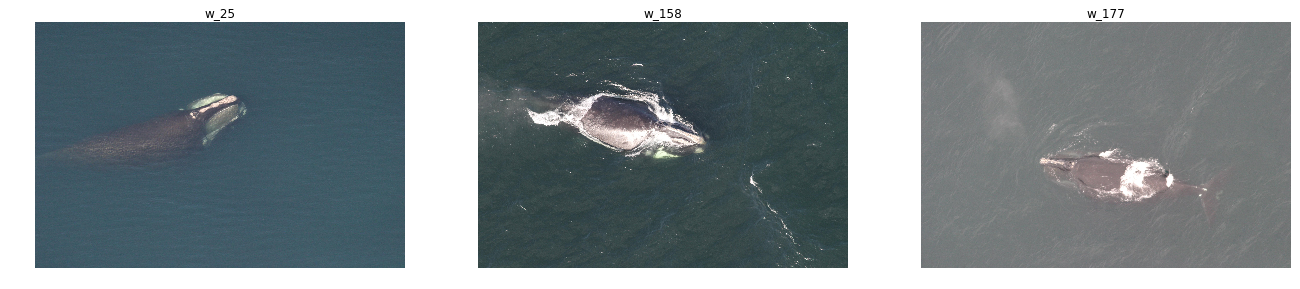

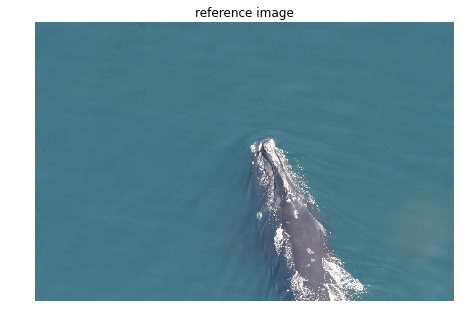

In [9]:
img_path = "/kaggle/whales/imgs"
# this is the image into the colors of which we want to map
ref_image = cv2.imread(path.join(img_path, "w_422.jpg"))
# images picked to illustrate different problems arising during algorithm application
image_names = ["w_25.jpg", "w_158.jpg", "w_177.jpg"]
image_paths = map(lambda t: path.join(img_path, t), image_names)
images = map(lambda p: cv2.imread(p), image_paths)

# let's see what we've got
image_titles = map(lambda i: path.splitext(i)[0], image_names)
show_images(images, image_titles, scale = 0.8)

show_images([ref_image], ["reference image"], scale = 0.8)

In [10]:
#Pyramid Down & blurr
# Easy-peesy
def pyr_blurr(image):
    return cv2.GaussianBlur(cv2.pyrDown(image), (7, 7), 30.)

ref_image = pyr_blurr(ref_image)
images = map(lambda i: pyr_blurr(i), images)


##Histogram Specification
####For all 3 color channels of each image:
1. Create histograms: reference image, input image
2. Create CDFs:
CDF is defined as $H_i= {N \over |I|} \sum\limits_{j=0}^{i}h_j$, where $h_j$ is the j-th bin of histogram $h$, $N$ is the maximum color value (255 in our case)
3. Map image to reference, i.e. for color $i$ in the input image, find color $j$ in the reference image: $\DeclareMathOperator*{\argmin}{\arg\!\min} j = \argmin_{k}{|H^{inp}_i - H^{ref}_k|}$

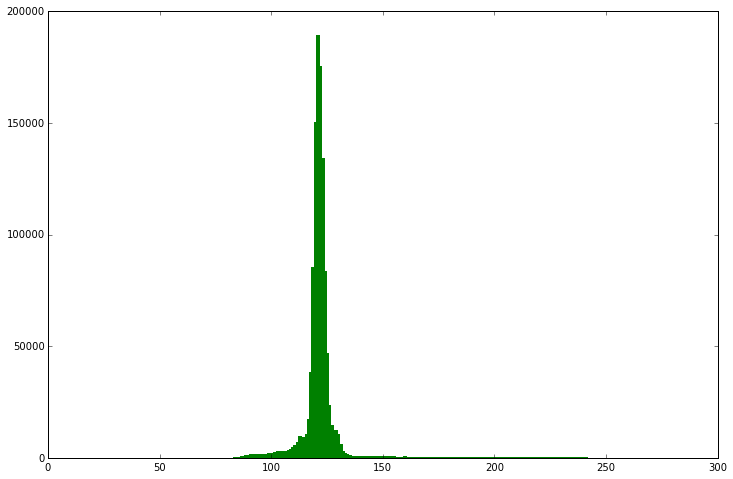

In [11]:
# here is the histogram of the reference image green channel:
hist_green = cv2.calcHist([ref_image], [1], None, [256], np.array([0, 255]))
fig = plt.figure()
plt.bar(np.arange(256), hist_green, width=2, color='g', edgecolor='none')
fig.set_size_inches(np.array(fig.get_size_inches(), dtype=np.float) * 2)
plt.show()


The above histogram has two peaks with lots of 0 values - not surprising, since we are computing it over the entire image. We need to mask off the background

Let's find the CDF. This code is heavily influenced by the LINQ way of doing everything at once without writing loops. I am starting to do better in Python, though, I promise.

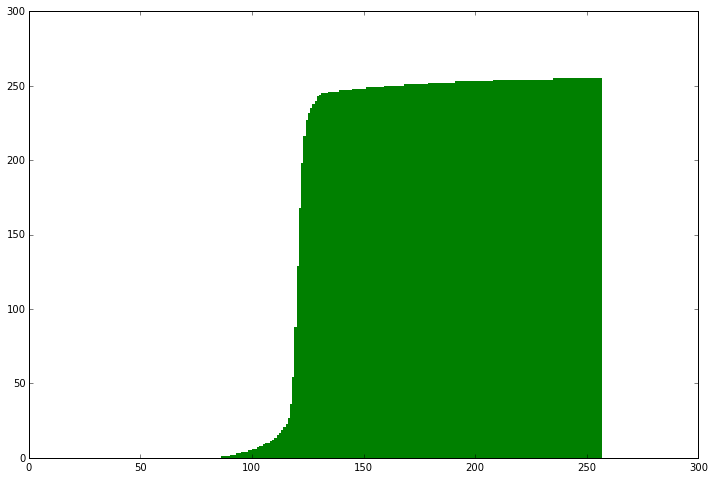

In [12]:
old_images = images
images = [ref_image]

# always return colors between 0 and 255
def saturate (v):
    return map(lambda a: min(max(round(a), 0), 255), v)

# given a list of images, create masks for them
def get_masks(images):
    def mask(im):
        mask = np.zeros_like(im[:,:,0])
        mask[:]=255
        return mask
    return map(lambda i: mask(i), images)

# list of masks
maskHull = get_masks(images)
# list of lists of channels
channels = map(lambda i: cv2.split(i), images)
# match mask to channel
imMask = zip(channels, maskHull)
# area of the image (the |I| constant in the CDF formaula above)
nonZeros = map(lambda m: cv2.countNonZero(m), maskHull)

# grab three histograms - one for each channel
histPerChannel = map(lambda (c, mask): \
                     [cv2.calcHist([cimage], [0], mask,  [256], np.array([0, 255])) for cimage in c], imMask)
# compute the cdf's. 
# they are normalized & saturated: values over 255 are cut off.
cdfPerChannel = map(lambda (hChan, nz): \
                     [saturate(np.cumsum(h) * 255.0 / nz) for h in hChan], zip(histPerChannel, nonZeros))

# let's see a cdf over the green channel (plot the first image CDF)
fig = plt.figure()
plt.bar(np.arange(256), cdfPerChannel[0][1], width=2, color='g', edgecolor='none')
fig.set_size_inches(np.array(fig.get_size_inches(), dtype=np.float) * 2)
plt.show()


###Putting it all together


In [13]:
# code above neatly in one function   
def calc_hist(images, masks):
    channels = map(lambda i: cv2.split(i), images)
    imMask = zip(channels, masks)
    nonZeros = map(lambda m: cv2.countNonZero(m), masks)
    
    # grab three histograms - one for each channel
    histPerChannel = map(lambda (c, mask): \
                         [cv2.calcHist([cimage], [0], mask,  [256], np.array([0, 255])) for cimage in c], imMask)
    # compute the cdf's. 
    # they are normalized & saturated: values over 255 are cut off.
    cdfPerChannel = map(lambda (hChan, nz): \
                        [saturate(np.cumsum(h) * 255.0 / nz) for h in hChan], \
                        zip(histPerChannel, nonZeros))
    
    return np.array(cdfPerChannel)

# compute color map based on minimal distances beteen cdf values of ref and input images    
def getMin (ref, img):
    l = [np.argmin(np.abs(ref - i)) for i in img]
    return np.array(l)

# compute and apply color map on all channels of the image
def map_image(image, refHist, imageHist):
    # each of the arguments contains histograms over 3 channels
    mp = np.array([getMin(r, i) for (r, i) in zip(refHist, imageHist)])

    channels = np.array(cv2.split(image))
    mappedChannels = np.array([mp[i,channels[i]] for i in range(0, 3)])
    
    return cv2.merge(mappedChannels).astype(np.uint8)

# compute the histograms on all three channels for all images
def histogram_specification(ref, images, masks):
        cdfs = calc_hist(images, masks)
        mapped = [map_image(images[i], ref[0], cdfs[i, :, :]) for i in range(len(images))]
        return mapped

Reference Image


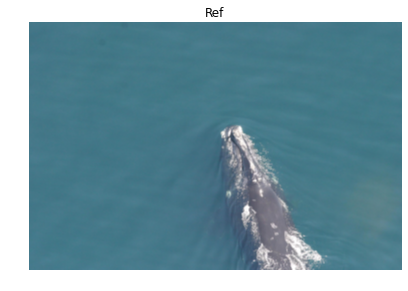

Original Images


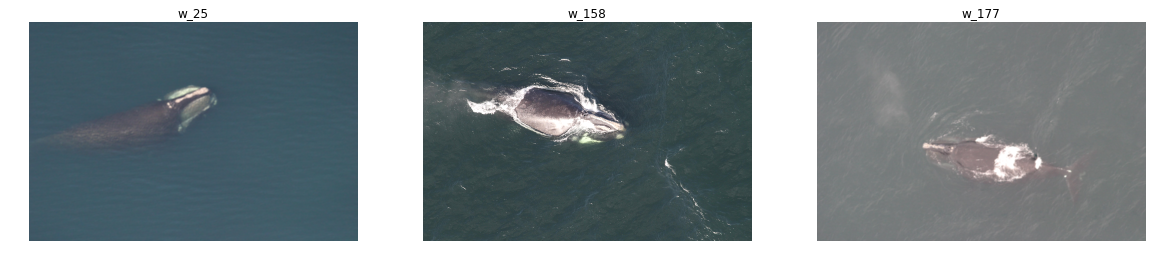

Mapped Images


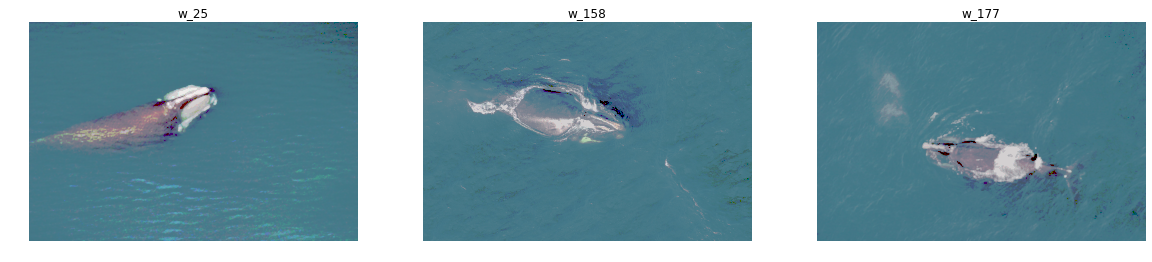

In [14]:
# the fruit of our labor
images = old_images
refMask = get_masks([ref_image])
refHist = calc_hist([ref_image], refMask)
masks = get_masks(images)
histSpec = histogram_specification(refHist, images, masks)

print "Reference Image"
show_images([ref_image], ["Ref"], scale = 0.9)
print "Original Images"
show_images(images, titles = image_titles, scale = 0.9)
print "Mapped Images"
show_images(histSpec, titles = image_titles, scale = 0.9)